In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, os, logging, json, random, wandb, shap
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

In [2]:
path = '/data/jlai/ntups/csv/jet_faking_BDT_input_basic.csv'
df = pd.read_csv(path)
df.describe()

,balance,BDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,metsig,metsigres,met,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,weights,label
count,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,-1.745489e+02,1.251438e-01,-1.663472e+03,-4.661989e+02,-1.848742e+02,4.027364e-01,2.738863e+00,-1.317202e+02,-1.313245e+02,-1.842713e+02,...,1.190690e+01,2.709180e+04,1.947991e+05,1.931356e+05,8.173447e+05,8.082155e+03,9.400769e+03,1.752871e+00,6.037499e-01,1.390112e-03
std,3.835393e+02,1.348625e-01,1.103691e+04,4.983897e+02,3.894295e+02,6.314438e-01,6.313106e-01,3.400961e+02,3.402509e+02,3.897176e+02,...,1.038910e+01,2.307818e+04,1.623949e+05,1.632818e+05,8.139494e+05,1.485037e+04,5.880428e+03,1.232225e+00,7.646898e+00,3.725829e-02
min,-9.990000e+02,-3.265468e-01,-1.712589e+05,-9.990000e+02,-9.990000e+02,0.000000e+00,1.167295e-02,-9.990000e+02,-9.990000e+02,-9.990000e+02,...,2.269695e-01,8.526343e+03,1.000000e+05,2.001940e+03,1.500329e+05,-9.990000e+02,0.000000e+00,0.000000e+00,-9.143369e+01,0.000000e+00
25%,9.546858e-01,8.068899e-03,0.000000e+00,-9.990000e+02,4.369926e-02,5.094965e-02,2.728096e+00,2.204334e-01,5.477069e-01,3.878704e-01,...,3.802686e+00,1.057160e+04,1.177408e+05,1.162434e+05,2.738635e+05,-9.990000e+02,4.993511e+03,1.000000e+00,1.026595e-04,0.000000e+00
50%,1.283851e+00,1.647640e-01,0.000000e+00,-2.735425e+00,4.694079e-01,1.503438e-01,2.991172e+00,1.017702e+00,2.089735e+00,2.023582e+00,...,1.024574e+01,1.767059e+04,1.480967e+05,1.473863e+05,4.551331e+05,-9.990000e+02,8.329055e+03,2.000000e+00,1.174600e-02,0.000000e+00
75%,2.922425e+00,2.371679e-01,0.000000e+00,1.512880e-01,2.476912e+00,4.133940e-01,3.090613e+00,2.863652e+00,3.105098e+00,3.039348e+00,...,1.590387e+01,3.643209e+04,2.160463e+05,2.158321e+05,1.013744e+06,2.159741e+04,1.265224e+04,3.000000e+00,5.386639e-02,0.000000e+00
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141592e+00,...,2.823775e+02,6.173285e+06,1.470684e+08,1.470684e+08,1.490961e+08,5.999986e+04,1.022158e+05,4.000000e+00,1.221239e+04,1.000000e+00


In [4]:
# === Data Perparation ===
df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()

df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

# Define X (features) and y (labels)
# Vars_drop = ['weights', 'label', 'process']
X = df_ml_input.drop(Vars_drop, axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']

random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

Number of event with negative weights : 218306


,balance,BDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_phterm_jetterm,ph_phi,jet_central_eta,jet_central_pt2,...,metsig,metsigres,met_noJVT,softerm,n_jet_central,weights,label,failJVT_jet_pt1,ph_eta,ph_pt
count,2.712769e+06,3.299733e+06,3.299732e+06,1.759863e+06,2.685312e+06,3.299733e+06,2.859950e+06,3.299733e+06,2.712769e+06,1.759863e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,977687.000000,3.299733e+06,3.299733e+06
mean,3.838187e+00,1.251438e-01,-1.663472e+03,-1.055280e-03,1.404322e+00,4.027364e-01,2.100537e+00,-2.322857e-03,1.122273e-03,1.301373e+05,...,1.190690e+01,2.709180e+04,1.931356e+05,9.400769e+03,1.752871e+00,6.196378e-01,1.390112e-03,0.000036,4.619389e+00,5.638744e-06
std,6.130255e+00,1.348625e-01,1.103691e+04,1.698739e+00,1.176454e+00,6.314438e-01,1.085866e+00,1.819052e+00,1.077024e+00,1.853047e+05,...,1.038910e+01,2.307818e+04,1.632818e+05,5.880428e+03,1.232225e+00,7.645627e+00,3.725829e-02,0.000009,4.657088e+02,4.934680e-06
min,3.173358e-02,-3.265468e-01,-1.712589e+05,-3.141591e+00,1.192093e-07,0.000000e+00,0.000000e+00,-3.141592e+00,-2.499994e+00,2.000003e+04,...,2.269695e-01,8.526343e+03,2.001940e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000017,3.966429e-01,1.995369e-07
25%,1.127429e+00,8.068899e-03,0.000000e+00,-1.266605e+00,1.804473e-01,5.094965e-02,1.077754e+00,-1.578759e+00,-7.428238e-01,3.167094e+04,...,3.802686e+00,1.057160e+04,1.162434e+05,4.993511e+03,1.000000e+00,1.428430e-03,0.000000e+00,0.000030,7.511125e-01,1.213521e-06
50%,1.535997e+00,1.647640e-01,0.000000e+00,-7.278919e-04,1.257375e+00,1.503438e-01,2.536042e+00,-6.129133e-03,-1.606467e-03,6.061452e+04,...,1.024574e+01,1.767059e+04,1.473863e+05,8.329055e+03,2.000000e+00,1.519263e-02,0.000000e+00,0.000038,1.271312e+00,4.487454e-06
75%,3.771265e+00,2.371679e-01,0.000000e+00,1.260984e+00,2.651747e+00,4.133940e-01,3.115461e+00,1.571243e+00,7.461343e-01,1.416852e+05,...,1.590387e+01,3.643209e+04,2.158321e+05,1.265224e+04,3.000000e+00,6.219316e-02,0.000000e+00,0.000044,2.644231e+00,8.563076e-06
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141584e+00,2.499999e+00,3.397636e+06,...,2.823775e+02,6.173285e+06,1.470684e+08,1.022158e+05,4.000000e+00,1.221239e+04,1.000000e+00,0.000050,8.314374e+05,1.999992e-05


Number of nan in each variable: 
balance                  586964
BDTScore                      0
dmet                          1
dphi_jj                 1539870
dphi_met_central_jet     614421
dphi_met_phterm               0
dphi_phterm_jetterm      439783
ph_phi                        0
jet_central_eta          586964
jet_central_pt2         1539870
jetterm                       0
metsig                        0
metsigres                     0
met_noJVT                     0
softerm                       0
n_jet_central                 0
weights                       0
label                         0
process                       0
failJVT_jet_pt1         2322046
ph_eta                        0
ph_pt                         0
dtype: int64
random number:  46


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:02:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


[22:06:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



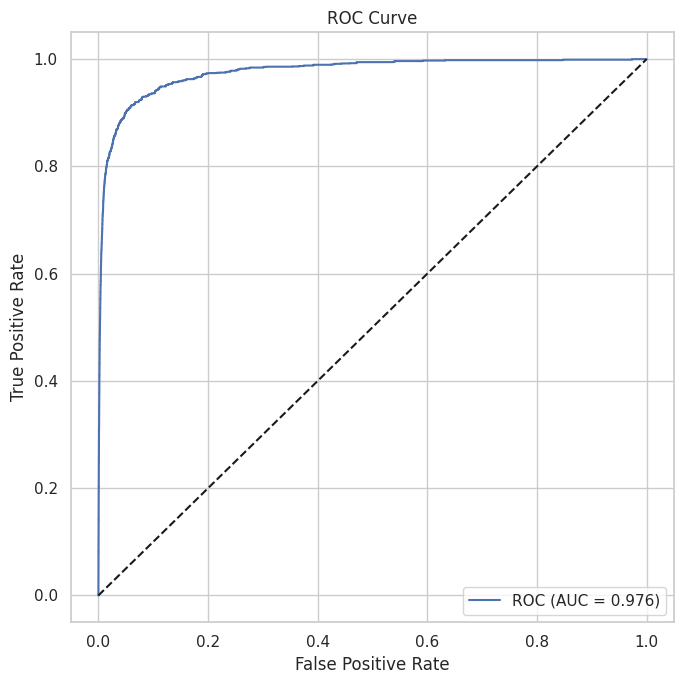

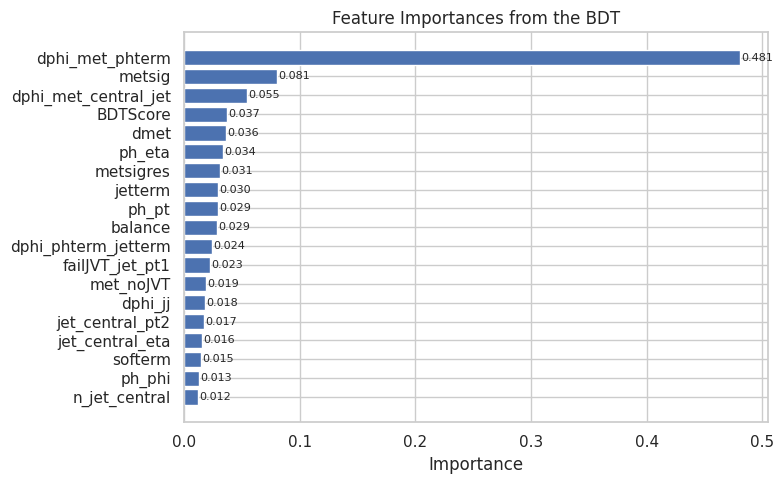

Best CV neg_log_loss,▁
Test Accuracy,▁
Test LogLoss,▁
Test ROC AUC,▁
Train Accuracy,▁
Train LogLoss,▁
Train ROC AUC,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇███
test_auc,▁▁▃▃▃▄▄▅▅▅▅▅▇▇██████████████████████████
test_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████
test_logloss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:02:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:04:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the de

In [7]:
wandb.init(project="Dark_ph BDT Grid", reinit=True, resume=False)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
}

xgb_clf = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric=['logloss', 'error', 'auc'],
    early_stopping_rounds=10,
    missing=np.nan,  # Let XGBoost handle any remaining NaNs
    random_state=random_num
)

grid_search = GridSearchCV(
    xgb_clf,
    param_grid,
    scoring='roc_auc',
    refit=True,
    cv=3,
    n_jobs=-1,
    verbose=1  # optional
)
grid_search.fit(X_train, y_train, sample_weight=sw_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                sample_weight_eval_set=[sw_train, sw_test],
                verbose=False)

best_model = grid_search.best_estimator_
wandb.config.update(grid_search.best_params_)
wandb.log({"Best CV neg_log_loss": grid_search.best_score_})
print("Best parameters found:", grid_search.best_params_)

df_ml_input["bdtscore2"] = best_model.predict_proba(df_ml_input.drop(Vars_drop, axis=1))[:, 1]

results = best_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

for i, (train_l, test_l, train_e, test_e, train_a, test_a) in enumerate(zip(train_loss, test_loss, train_error, test_error, train_auc, test_auc)):
    wandb.log({
        "train_logloss": train_l,
        "test_logloss": test_l,
        "train_error": train_e,
        "test_error": test_e,
        "train_auc": train_a,
        "test_auc": test_a,
        "iteration": i
    })

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

metrics = {
    "Train LogLoss": log_loss(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test LogLoss": log_loss(y_test, y_test_pred_proba, sample_weight=sw_test),
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test ROC AUC": roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
}

wandb.log(metrics)

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
tpr_sel = 217.13/374.83
fpr_sel = 5066.37/227609.78
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(metrics["Test ROC AUC"]))
# plt.scatter(fpr_sel, tpr_sel, color='orange', label='cut-flow point')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_gridsearch.png")
wandb.log({"ROC Curve": wandb.Image("roc_gridsearch.png")})
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(Vars_drop + ['bdtscore2'], axis=1).columns

plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(selected_columns)), importances[indices], align='center')

# Set y-ticks with feature names
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')

# Annotate each bar with the importance value
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=8)
plt.tight_layout()
plt.savefig("feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("feature_importance.png")})
plt.show()


wandb.finish()